# Time Series Traffic Analysis

In [1]:
%matplotlib notebook

import os
import shutil
import urllib3

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [63]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz"
PATH = "metro_interstate.csv.gz"


def fetch_data(url=URL, path=PATH):
    http = urllib3.PoolManager()
    with open(path, 'wb') as f:
        r = http.request('GET', url, preload_content=False)
        shutil.copyfileobj(r, f)
    

# Only need to run once!
fetch_data()

In [2]:
data = pd.read_csv(
    "metro_interstate.csv.gz",
    index_col="date_time",
    parse_dates=True
)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


<IPython.core.display.Javascript object>


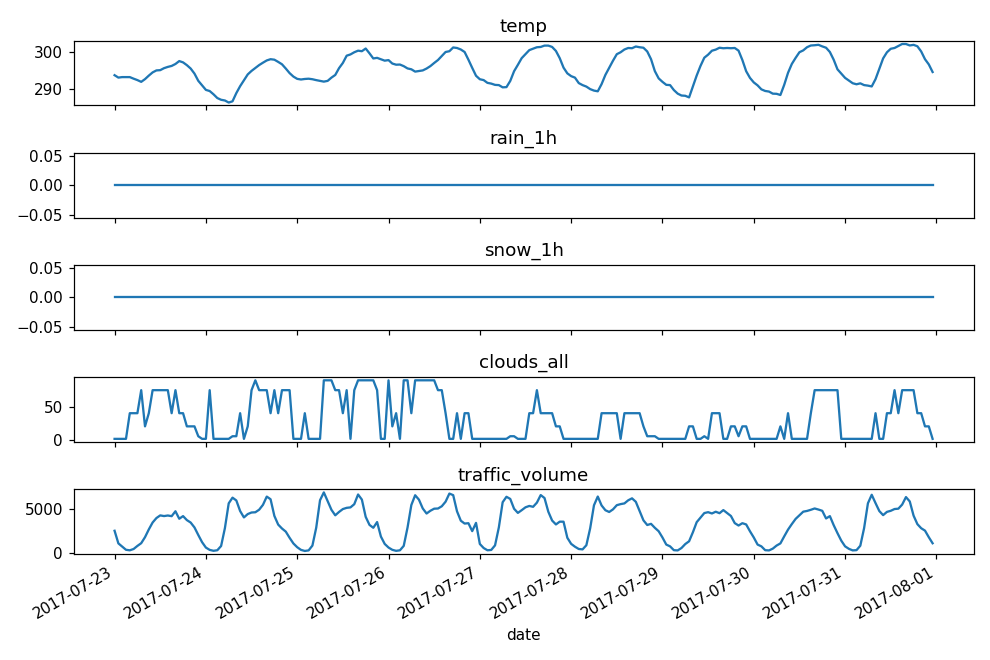

In [3]:
def plot_numeric_features(df=data, cols=["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]):
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, figsize=(9,6))
    
    for col, ax in zip(cols, axes):
        df[col].plot(ax=ax)
        ax.set_title(col)
        
        if ax == axes[-1]:
            ax.set_xlabel("date")
    
    fig.tight_layout()
    return ax


# Plot features in date range
_ = plot_numeric_features(data.loc["2017-07-23":"2017-07-31"])

<IPython.core.display.Javascript object>


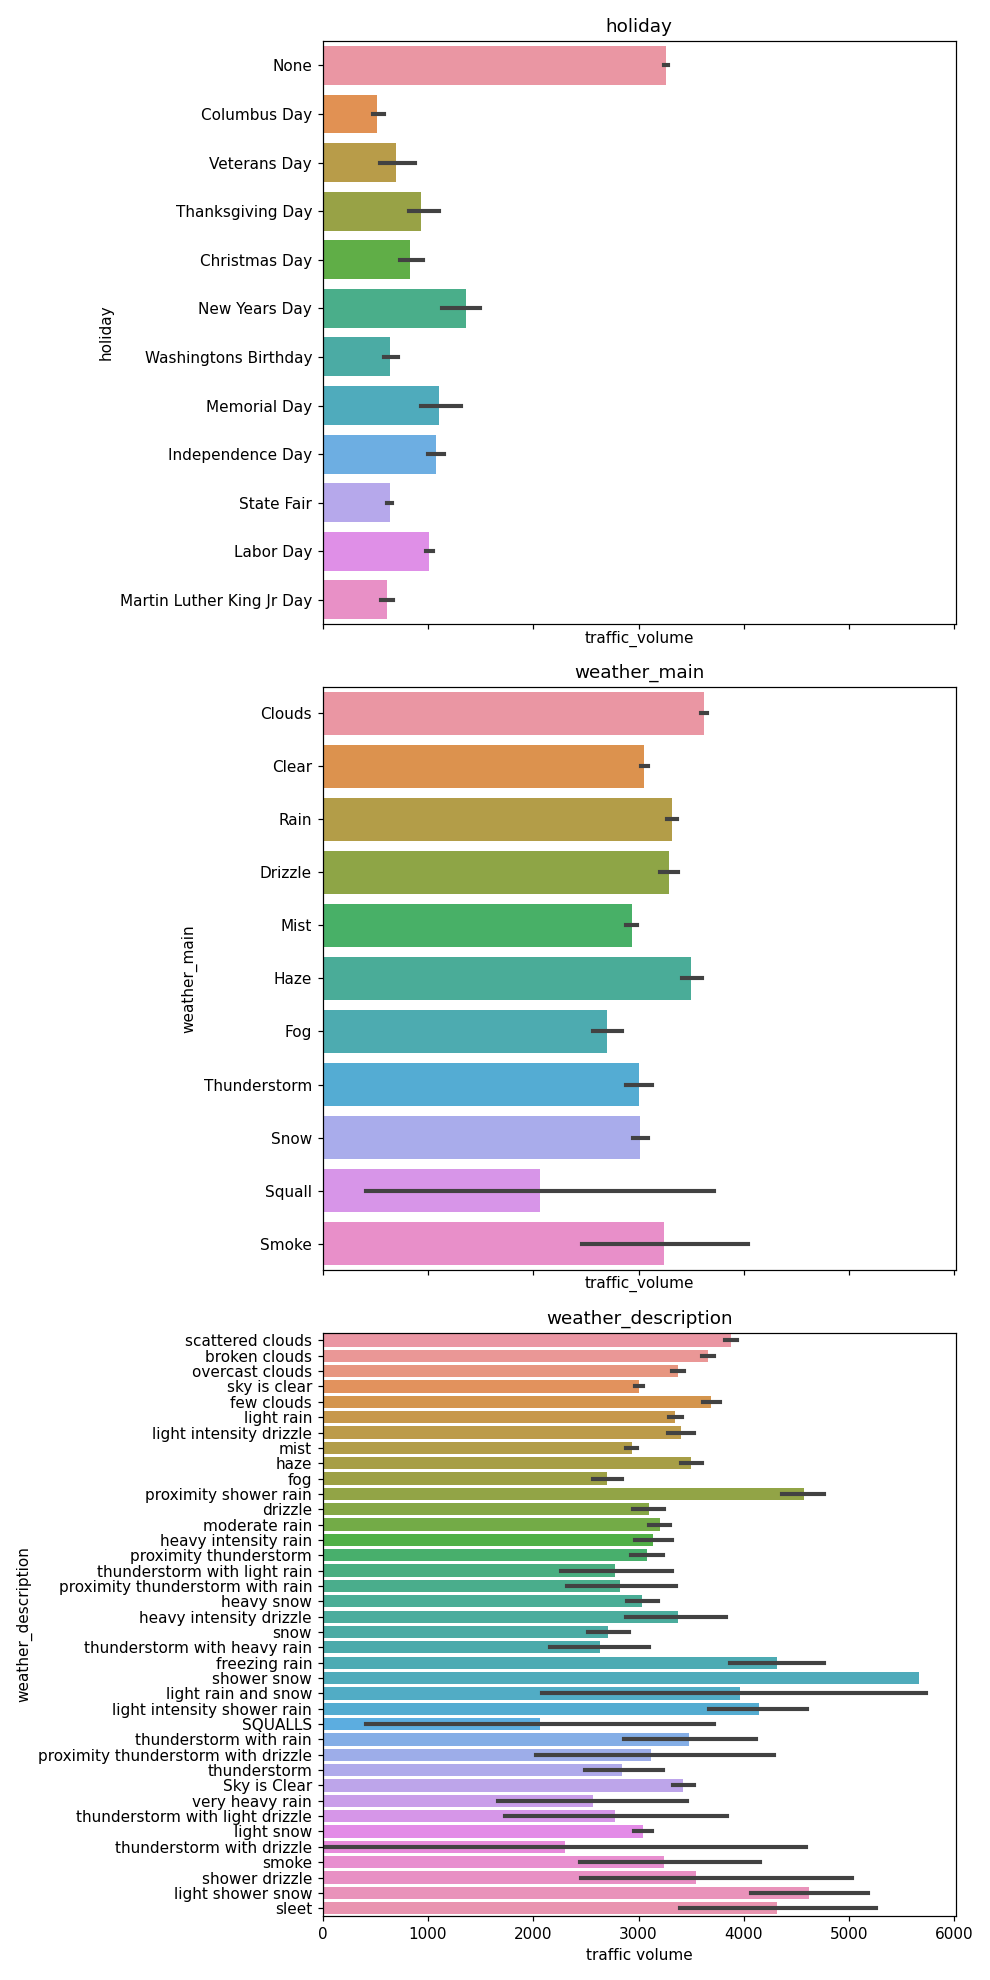

In [4]:
def plot_categorical_features(df=data, cols=['holiday', 'weather_main', 'weather_description']):
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, figsize=(9,18))
    
    for col, ax in zip(cols, axes):
        sns.barplot(x='traffic_volume', y=col, data=df, ax=ax)
        ax.set_title(col)
        
        if ax == axes[-1]:
            ax.set_xlabel('traffic volume')
    
    
    fig.tight_layout()
    return ax


_ = plot_categorical_features(data)

## Time Based Transformers

In this section we will extract the following features:

- cyclic encoding of hour of day
- cyclic encoding of day of year
- binarize if the day is a holiday or not
- one hot encode the weather description 

In [10]:
TARGET = "traffic_volume"
COLS = ["date_time", "holiday", "weather_main", "temp", "rain_1h", "snow_1h", "clouds_all"]


def make_sklearn_data(df=data, target=TARGET, cols=COLS):
    # Add the datetime column back to the main dataframe
    df = df.reset_index()
    X, y = df[cols], df[target]
    return X, y

### Cyclic Encoder

The cyclic encoder takes a single column of the data that is in a datetime format and extracts a cos/sin representation that ensures the min/max values are closer together than to the median value. E.g. it transforms the data from a line into a circle.

<IPython.core.display.Javascript object>


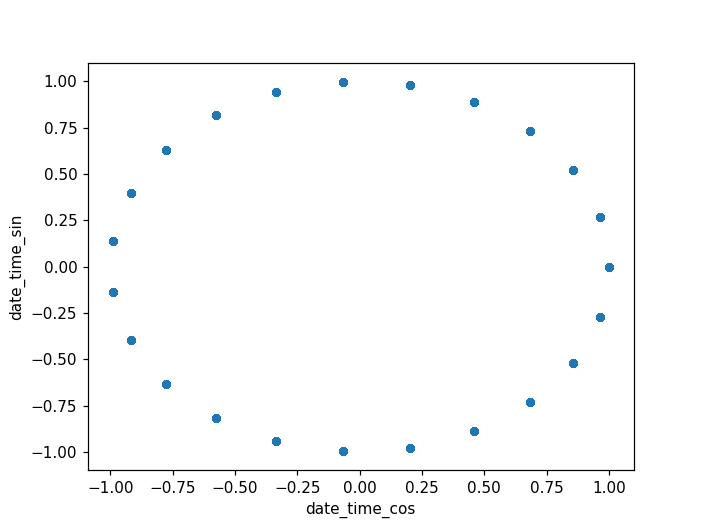

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="hour"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "minute":
            return x.dt.minute
        
        if self.date_extract == "hour":
            return x.dt.hour
        
        if self.date_extract == "week":
            return x.dt.isocalendar().week
        
        if self.date_extract == "month":
            return x.dt.month
        
        if self.date_extract == "year":
            return x.dt.isocalendar().day
        
        raise NotImplementedError(f"{self.date_extract} is not a valid component")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(data.reset_index()["date_time"])
ce.plot(x="date_time_cos", y="date_time_sin", kind="scatter")

### Holiday Bins

The holiday binarizer is a simple transformer that uses the string value of the holiday column to return 1 if the value is not 'None', zero otherwise. This transformer does not necessarily learn from the data, but is more easily utilized inside of a pipeline.

In [7]:
class HolidayBins(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.asarray([[
            0 if xi == 'None' else 1 for xi in X
        ]]).T

### Feature Extraction

Feature extraction is a Pipeline that applies specific transformers to specific columns. The goal is to go from as raw data as possible through a prediction transformation process. The function `make_traffic_pipeline` prepends the feature extraction process to any other steps.

Note that more feature extraction experimentation could be done. For example:

1. Adding in the previous n timesteps data worth of traffic/weather
2. Instead of binarizing holiday, one hot encode or ordinally encode the holiday 
3. Instead of one hot encoding the weather, use a weighted or hashed weather description
4. Dropping columns

In [35]:
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder


# This is the base feature extraction pipeline that will be applied to all incoming dat
extraction = Pipeline([
    # The column selector only modifies the date_time, holiday, and weather_main columns
    # passing through all other columns without modification
    ('column_selection', ColumnTransformer([
        # Extract the hour of day and day of year components from the date
        ('time_components', FeatureUnion([
            ('hour_of_day', CyclicEncoder(date_extract="hour")),
            ('day_of_year', CyclicEncoder(date_extract="year")),
        ]), 'date_time'),
        # Convert holiday to a 1 if its a holiday, 0 otherwise
        ('holiday_binerize', HolidayBins(), 'holiday'),
        # One hot encode our categorical weather descriptions
        ('weather', OneHotEncoder(handle_unknown='ignore'), ['weather_main']),
    ], remainder="passthrough")),    
])


def make_traffic_pipeline(model, append_transformers=None, fe=extraction):
    """
    Composes a single model using the base feature extraction pipeline. Can
    additionally specify other steps using append_transformers, or a different
    base feature extraction method using fe.
    
    Parameters
    ----------
    model : sklearn.Estimator
        The regressor to use to predict traffic with
    
    append_transformers : list of Transformers
        Any additional transformers to append to the Pipeline
    
    fe : sklearn.Pipeline
        The base feature extraction pipeline to compose with
    
    Returns
    -------
    model : sklearn.Pipeline
        A fully composed and unfitted sklearn pipeline.
    """
    # clone the pipeline to ensure it's not fitted
    pipe = clone(fe)
    
    # append any steps to the pipeline
    if append_transformers:
        for step in append_transformers:
            pipe.steps.append(step)
    
    pipe.steps.append(["model", clone(model)])
    return pipe

### Test the Feature Extraction Pipeline

The next code snippet shows how to compose a model using the feature extraction pipeline.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts


# Note: don't use tts for real, this is time series data!
X_train, X_test, y_train, y_test = tts(*make_sklearn_data(), test_size=0.2)

model = make_traffic_pipeline(LinearRegression())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.670802582883026

## Time Series Cross Validation

Because we want to learn from history and not use future values to predict past values, we need to use the `TimeSeriesSplit` for cross validation.

In [31]:
from functools import partial
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rmse = partial(mean_squared_error, squared=False)


def time_series_evaluate(model, X, y):
    """
    Performs time series cross validation on the model, returning the
    cross validated r2, mse, and mae of the regressor, along with the 
    final fitted model, fitted on all of the data.
    """
    cv = TimeSeriesSplit(12)
    scores = {}
    
    scores["r2"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(r2_score))
    scores["mse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_squared_error))
#     scores["rmse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(rmse))
    scores["mae"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
    
    model.fit(X, y)
    return model, scores

In [32]:
# Linear Model
X, y = make_sklearn_data()
lm = make_traffic_pipeline(LinearRegression())
time_series_evaluate(lm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('hour_of_day',
                                                                                   CyclicEncoder()),
                                                                                  ('day_of_year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'date_time'),
                                                  ('holiday_binerize',
                                                   HolidayBins(), 'holiday'),
                                                  ('weather',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                             

In [36]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures




qm = make_traffic_pipeline(SGDRegressor(), [('quad', PolynomialFeatures(2))])
time_series_evaluate(qm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('hour_of_day',
                                                                                   CyclicEncoder()),
                                                                                  ('day_of_year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'date_time'),
                                                  ('holiday_binerize',
                                                   HolidayBins(), 'holiday'),
                                                  ('weather',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                             